# Execution graph tutorial

If you already executed the basic_example.ipynb, you should be familiar with the Pipeline class. In this tutorial, we will explore the ExecutionGraph concept.

Let's import the needed classes and define a dummy task class that we will use for our example.

In [1]:
import traceback
from netunicorn.base import ExecutionGraph, Task

class DummyTask(Task):
    def run(self):
        pass

## Basic graphs

ExecutionGraph is a foundational concept in netUnicorn, defining the execution flow of the tasks. It is a directedd graph with all tasks connected by directed edges that define which task would be executed after the other.

The ExecutionGraph contains the graph itself and several parameters to control the execution flow. The graph is a networkx.DiGraph object, with task (or any other) instances as nodes and edges connecting them.

The graph is valid only under certain conditions, which are checked by the is_execution_graph_valid method. Full rules are available in the ExecutionGraph class docstring: 

In [2]:
help(ExecutionGraph)

Help on class ExecutionGraph in module netunicorn.base.execution_graph:

class ExecutionGraph(builtins.object)
 |  ExecutionGraph(early_stopping: 'bool' = True, report_results: 'bool' = True, environment_definition: 'Optional[EnvironmentDefinition]' = None)
 |  
 |  ExecutionGraph is a class that allows you to flexibly define a graph of tasks and their order.
 |  It has the next rules:
 |  
 |  | 1. Execution graph is a directed graph.
 |  | 2. Execution graph always starts with a node "root" (this node is automatically added in the new graph during initialization).
 |  | 3. Any node of type TaskDispather would be dispatched to Task. Any node of type Task would be executed. Any nodes of other types would not be executed but would be treated as synchronization points.
 |  | 4. Number of components in the graph must be 1, the graph should be weakly connected, and all nodes should be accessible from the root node.
 |  | 5. Any edge have either "strong" or "weak" type. If no type provided,

Let's create an empty graph and explore it:

The graph is valid: True


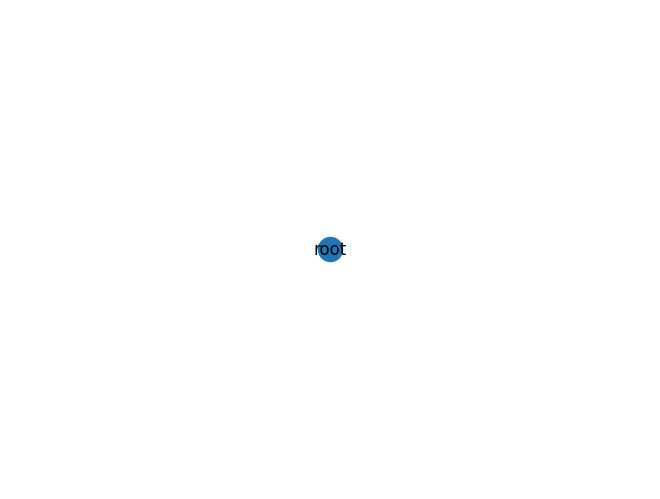

In [3]:
eg = ExecutionGraph()
eg.draw()
print(f"The graph is valid: {ExecutionGraph.is_execution_graph_valid(eg)}")

As you can see, the graph contains a single node named "root". This is the default node that is created when the graph is created. It is used as a starting point for the execution and should always be presented in the graph. 

Currently, we don't have any tasks in our execution graph. Let's add a dummy task there.

Traceback (most recent call last):
  File "/tmp/ipykernel_720896/1192275093.py", line 5, in <module>
    ExecutionGraph.is_execution_graph_valid(eg)
  File "/home/kell/repos/netunicorn/netunicorn-base/src/netunicorn/base/execution_graph.py", line 105, in is_execution_graph_valid
    raise ValueError(
ValueError: Execution graph must be a weakly connected directed graph


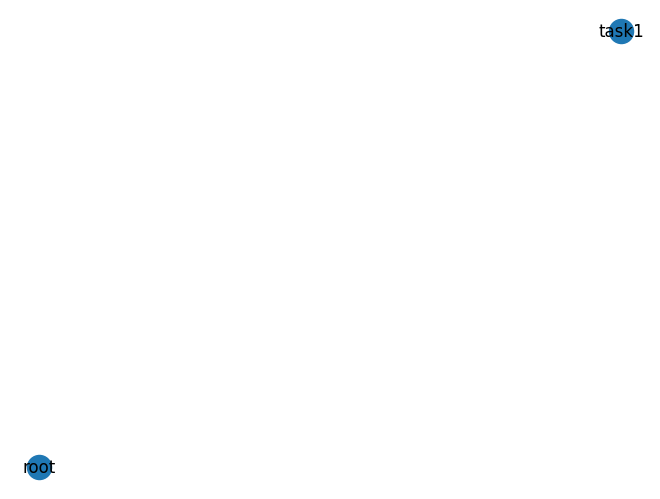

In [4]:
task1 = DummyTask(name="task1")
eg.graph.add_node(task1)
eg.draw()
try:
    ExecutionGraph.is_execution_graph_valid(eg)
except ValueError:
    traceback.print_exc()

We added a task, but we haven't defined any edges and executor will not be able to run this graph. Each task should be accessible from the root node by a directed path. Let's add an edge between the root node and our task.

The graph is valid: True


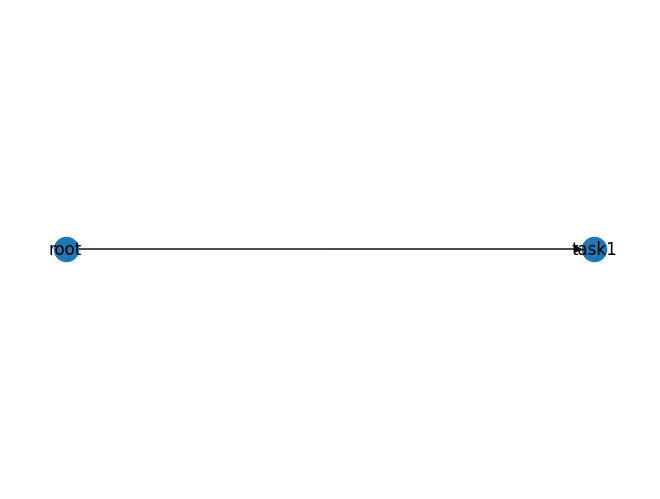

In [5]:
eg.graph.add_edge('root', task1)
eg.draw()
print(f"The graph is valid: {ExecutionGraph.is_execution_graph_valid(eg)}")

Now our graph is valid and defines a simple execution flow. The executor will start from the root node, then execute the task1 and finish the execution.

Let's make our graph more complicated. We will add two more tasks and connect them to the task1.

The graph is valid: True


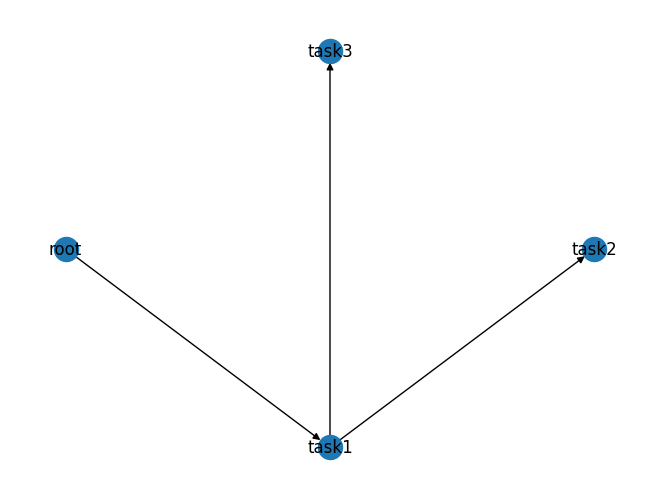

In [6]:
task2 = DummyTask(name="task2")
task3 = DummyTask(name="task3")

eg.graph.add_edge(task1, task2)
eg.graph.add_edge(task1, task3)
eg.draw()
print(f"The graph is valid: {ExecutionGraph.is_execution_graph_valid(eg)}")

At this point, our execution flow is defined as follows: 
- Executor will start from the root node
- Then it will execute the task1
- Then it will execute the task2 and task3 in parallel

As task1, task2, and task3 are instances of the class Task, they would be executed by the executor. Any node, that is not an instance of the Task class, will be used as a "synchronization point" in the graph - executor will wait until all the tasks connected to this node are finished and then continue the execution.

Let's add a synchronization point to our graph, connect tasks 2 and 3 to it and add a new task that will be executed after the synchronization point.

The graph is valid: True


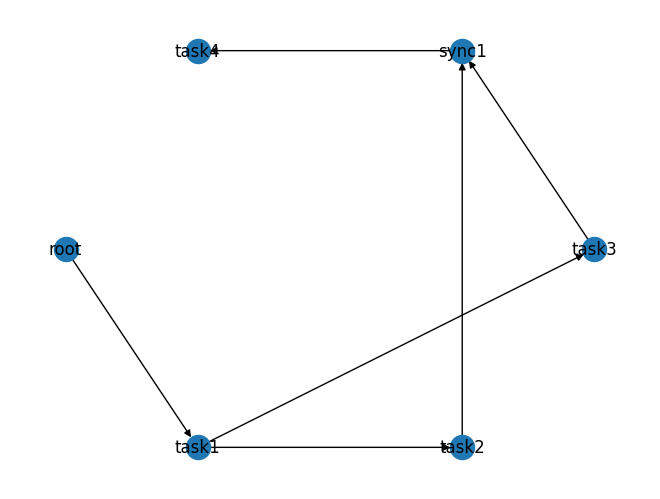

In [7]:
# synchornization points

eg.graph.add_edge(task2, "sync1")
eg.graph.add_edge(task3, "sync1")

task4 = DummyTask(name="task4")

eg.graph.add_edge("sync1", task4)
eg.draw()
print(f"The graph is valid: {ExecutionGraph.is_execution_graph_valid(eg)}")

As you can see, the graph is valid and defines the following execution flow:
- Executor will start from the root node
- Then it will execute the task1
- Then it will execute the task2 and task3 in parallel
- It will stay at the synchronization point `sync1` until both task2 and task3 are finished
- Then it will execute the task4

You might notice the similar behavior earlier using the Pipeline class. The Pipeline class is a wrapper around the ExecutionGraph class, that provides a more convenient way to define the execution flow, and work exactly as the example provided above. Let's create a pipeline and draw it:

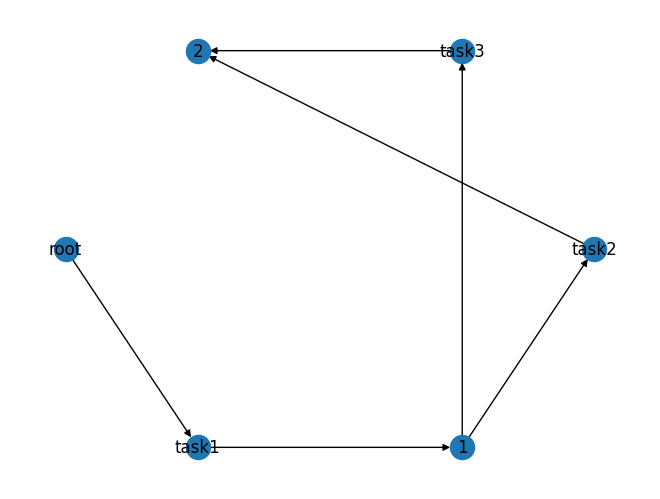

In [8]:
from netunicorn.base import Pipeline

Pipeline().then(task1).then([task2, task3]).draw()

## Cycles

ExecutionGraph allows you to define cycles in the execution flow. However, just connecting two tasks in a cycle will not work, as the executor will not be able to determine which task should be executed first:

Traceback (most recent call last):
  File "/tmp/ipykernel_720896/2597107242.py", line 4, in <module>
    ExecutionGraph.is_execution_graph_valid(eg)
  File "/home/kell/repos/netunicorn/netunicorn-base/src/netunicorn/base/execution_graph.py", line 125, in is_execution_graph_valid
    raise ValueError(
ValueError: Execution graph must be acyclic after removing all weak links. Otherwise your cycles will introduce deadlocks.


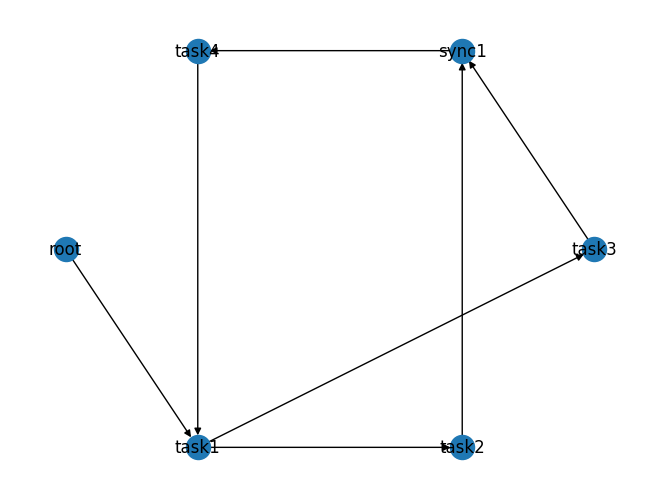

In [9]:
eg.graph.add_edge(task4, task1)
eg.draw()
try:
    ExecutionGraph.is_execution_graph_valid(eg)
except ValueError:
    traceback.print_exc()

To resolve this, ExecutionGraph defines two types of the edges: `strong` and `weak`, defined in the edge attribute `type`. The `strong` edge is the default type and defines both the prerequisites for a task and the order of execution. The `weak` edge defines only the order of execution, but not the prerequisites.

So, if a node has multiple incoming edges and some of them are `weak`, the executor will not wait for the tasks connected by `weak` edges to finish before executing the node. But, executor will traverse the `weak` edges and will execute tasks connected by them in the order defined by the edges.

Usually, you will use `weak` edges to close the cycles in the graph. Please note, that according to the graph rules, any node should be accessible from the root node by strong edges. Let's try to make the closing edge `weak`:

The graph is valid: True


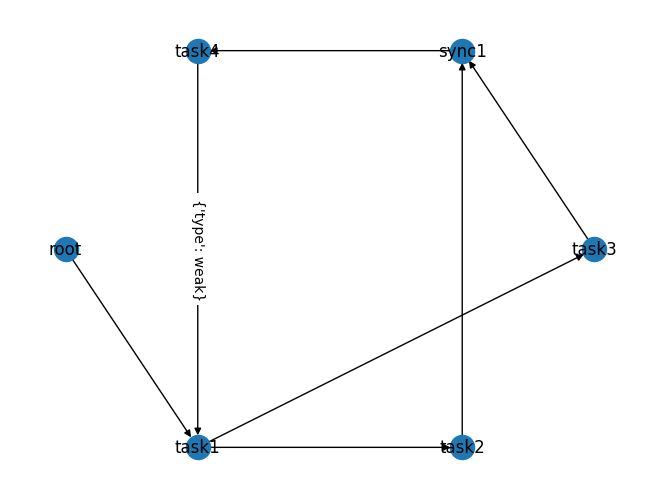

In [10]:
eg.graph.edges[task4, task1]['type'] = "weak"
eg.draw()
print(f"The graph is valid: {ExecutionGraph.is_execution_graph_valid(eg)}")

You also can define, how many times this particular edge should be traversed in the graph. After the edge is traversed the specified number of times, it will be removed from the graph. This allows you to define the cycles that will be executed only a certain number of times. Let's define the edge counter to 3:

The graph is valid: True


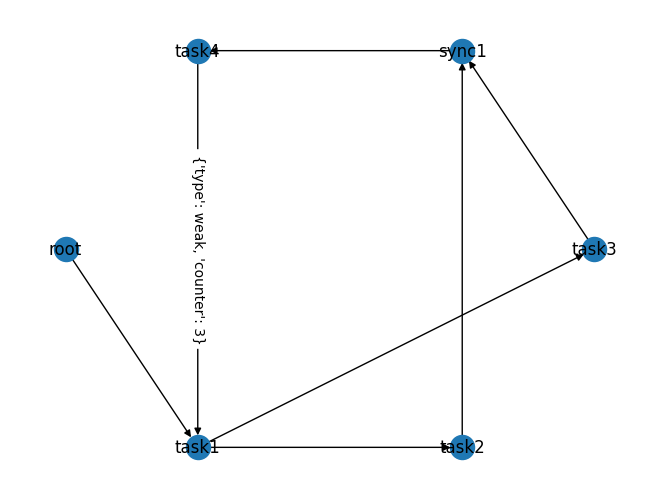

In [11]:
eg.graph.edges[task4, task1]['counter'] = 3
eg.draw()
print(f"The graph is valid: {ExecutionGraph.is_execution_graph_valid(eg)}")

This concept is implemented in the CyclePipeline class for simplicity of usage:

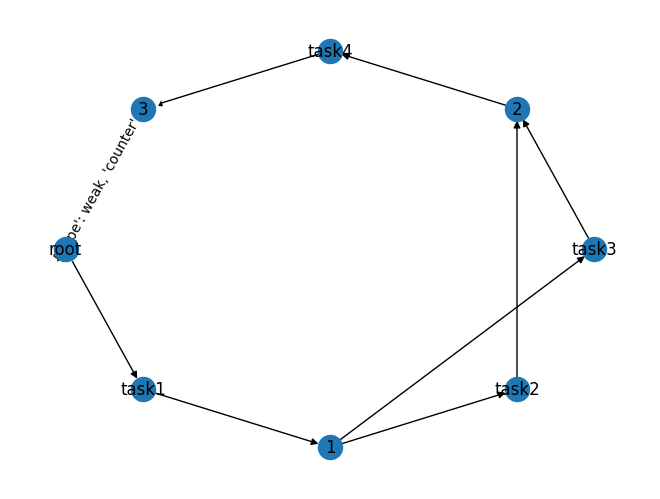

In [12]:
from netunicorn.base import CyclePipeline

CyclePipeline(cycles=4).then(task1).then([task2, task3]).then(task4).draw()

## traverse_on

The `traverse_on` attribute defines the conditions under which the edge will be traversed. It can be one of the following values:
- `success` - the edge will be traversed only if the task connected by this edge is finished successfully
- `failure` - the edge will be traversed only if the task connected by this edge is finished with an error
- `any` - the edge will be traversed in any case

See additional description in the ExecutionGraph class docstring.

The `traverse_on` attribute allows you to flexibly defines subgraphs in your execution graph that would be executed only if some conditions are met. Let's add a few tasks and define the `traverse_on` attribute for the edges:

The graph is valid: True


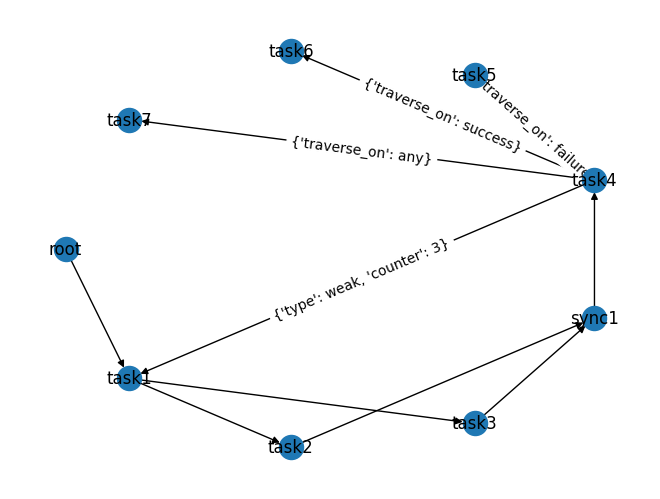

In [13]:
task5 = DummyTask(name="task5")
task6 = DummyTask(name="task6")
task7 = DummyTask(name="task7")
eg.graph.add_edge(task4, task5, traverse_on="failure")
eg.graph.add_edge(task4, task6, traverse_on="success")
eg.graph.add_edge(task4, task7, traverse_on="any")


eg.draw()
print(f"The graph is valid: {ExecutionGraph.is_execution_graph_valid(eg)}")

In this case, depending on the result of the task4, the executor will execute either task5 or task6. Task7 will be executed in any case.

## Validation override

WARNING: this field is provided for experienced users and shouldn't be used unless you know that your graph would be correctly executed. Please, use it with caution.

In the case when you need to define a graph that is not valid according to the rules described in the ExecutionGraph class docstring, but you know that it would be executed as you desire (e.g., due to specifics of your tasks or any other reason), you can override the validation by setting the `override_graph_validation` attribute of the ExecutionGraph to `True`. It disables all the validation checks:

The graph is valid: True


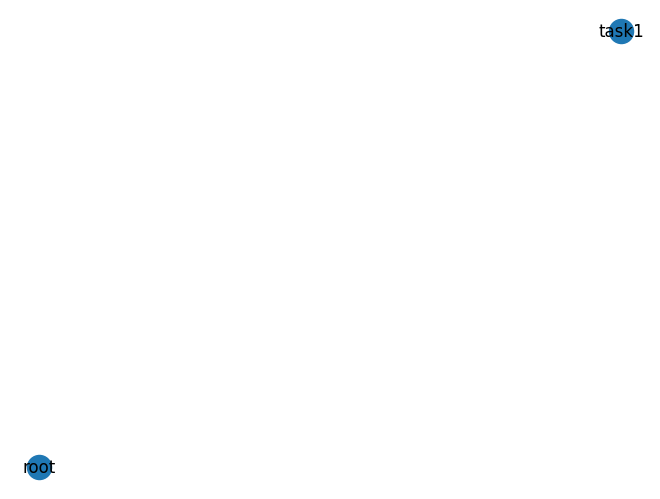

In [14]:
eg = ExecutionGraph()
eg.override_graph_validation = True
eg.graph.add_node(task1)
eg.draw()
print(f"The graph is valid: {ExecutionGraph.is_execution_graph_valid(eg)}")